## Import all cleaning

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import zipfile
import scipy.stats as st
import math
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime


# suppress futurewarnings from statistical packages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.ticker as mticker
from tabulate import tabulate
import plotly
import plotly.express as px

plotly.offline.init_notebook_mode()
#read data

zip_file = "../Dataset/AB_US_2020.zip"
try:
    with zipfile.ZipFile(zip_file, 'r') as z:
        z.extractall("Dataset/unZipped/")
        print("Extracted all")
except:
    print("Invalid file")
    
airbnbDS = pd.read_csv("Dataset/unZipped/AB_US_2020.csv")

#Going to drop neighbourhood_group because of have the values are null. 
#For both name and host name I will fill the empty slots with "N/A", 
#there is very few missing and I do not think name will be very important to regesion on price. 
#For all null values in reviews_per_month will be replaced with 0. 


airbnbDS = airbnbDS.drop("neighbourhood_group", axis = 1)


airbnbDS = airbnbDS.fillna(value= {'name': 'N/A', 'host_name':'N/A', 'reviews_per_month': 0})

airbnbDS = airbnbDS.dropna()

room_ID_dic = {'Entire home/apt': 1, 'Private room': 2,'Shared room': 3, 'Hotel room': 4}

airbnbDS['room_type_ID'] = airbnbDS['room_type'].apply(lambda x: room_ID_dic[x])

city_ID_dic = {'Asheville' : 1, 'Austin' : 2, 'Boston' :3, 'Broward County' :4, 'Cambridge':5,
       'Chicago':6, 'Clark County':7, 'Columbus':8, 'Denver':9, 'Hawaii':10,
       'Jersey City':11, 'Los Angeles':12, 'Nashville':13, 'New Orleans':14,
       'New York City':15, 'Oakland':16, 'Pacific Grove':17, 'Portland':18,
       'Rhode Island':19, 'Salem':20, 'San Clara Country':21, 'San Diego':22,
       'San Francisco':23, 'San Mateo County':24, 'Santa Cruz County':25,
       'Seattle':26, 'Twin Cities MSA':27, 'Washington D.C.':28}


airbnbDS['city_ID'] = airbnbDS['city'].apply(lambda x: city_ID_dic[x])

airbnbDS['last_review'] = pd.to_datetime(airbnbDS['last_review'])

airbnbDS['days_since_last_review'] = datetime.now() - airbnbDS['last_review']

airbnbDS['days_since_last_review'] = airbnbDS['days_since_last_review'].dt.days



Extracted all


C:\Users\clineman\Anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning:

Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.



In [15]:
airbnbDS

id                                               name  \
0          38585    Charming Victorian home - twin beds + breakfast   
1          80905                                   French Chic Loft   
2         108061  Walk to stores/parks/downtown. Fenced yard/Pet...   
3         155305                 Cottage! BonPaul + Sharky's Hostel   
4         160594                                Historic Grove Park   
...          ...                                                ...   
225936  45326130      Modern and cozy home located in Washington DC   
225950  45349877  Penthouse w/ Patio ‚òÜ Capitol Hill Condo ‚òÜ ...   
225955  45352724  MODERN ‚òÜ Well-Located Shaw Town Home ‚òÜ 2BR...   
225964  45385834      Brand new modern apartment with private entry   
226002  45472150  LUXE 1-BR STUDIO SPACE / Desirable Location + ...   

          host_id  host_name  \
0          165529    Evelyne   
1          427027    Celeste   
2          320564       Lisa   
3          746673    BonPaul   
4          769252  Elizabeth   
...           ...        ...   
225936   55489711       Amir   
225950    3850096        Ije   
225955    3850096        Ije   
225964   16561471     Victor   
226002  367917574       Tara   

                                            neighbourhood  latitude  \
0                                                   28804  35.65146   
1                                                   28801  35.59779   
2                                                   28801  35.60670   
3                                                   28806  35.57864   
4                                                   28801  35.61442   
...                                                   ...       ...   
225936          Union Station, Stanton Park, Kingman Park  38.90101   
225950                         Capitol Hill, Lincoln Park  38.88703   
225955     Howard University, Le Droit Park, Cardozo/Shaw  38.91626   
225964               Brightwood Park, Crestwood, Petworth  38.94358   
226002  Edgewood, Bloomingdale, Truxton Circle, Eckington  38.91457   

        longitude        room_type  price  minimum_nights  number_of_reviews  \
0       -82.62792     Private room     60               1                138   
1       -82.55540  Entire home/apt    470               1                114   
2       -82.55563  Entire home/apt     75              30                 89   
3       -82.59578  Entire home/apt     90               1                267   
4       -82.54127     Private room    125              30                 58   
...           ...              ...    ...             ...                ...   
225936  -77.00283  Entire home/apt    144               1                  1   
225950  -77.00586  Entire home/apt    132               2                  1   
225955  -77.02074  Entire home/apt    112               2                  1   
225964  -77.01283  Entire home/apt     78               1                  1   
226002  -77.00911  Entire home/apt     76               1                  1   

       last_review  reviews_per_month  calculated_host_listings_count  \
0       2020-02-16               1.14                               1   
1       2020-07-09               1.03                              11   
2       2019-11-30               0.81                               2   
3       2020-09-22               2.39                               5   
4       2015-10-19               0.52                               1   
...            ...                ...                             ...   
225936  2020-09-18               1.00                               1   
225950  2020-09-16               1.00                               8   
225955  2020-09-13               1.00                               8   
225964  2020-09-19               1.00                               1   
226002  2020-09-18               1.00                               1   

        availability_365             city  room_type_ID  city_ID  \
0                

## visulizations

Word cloud to show the most frequently used words in the description name

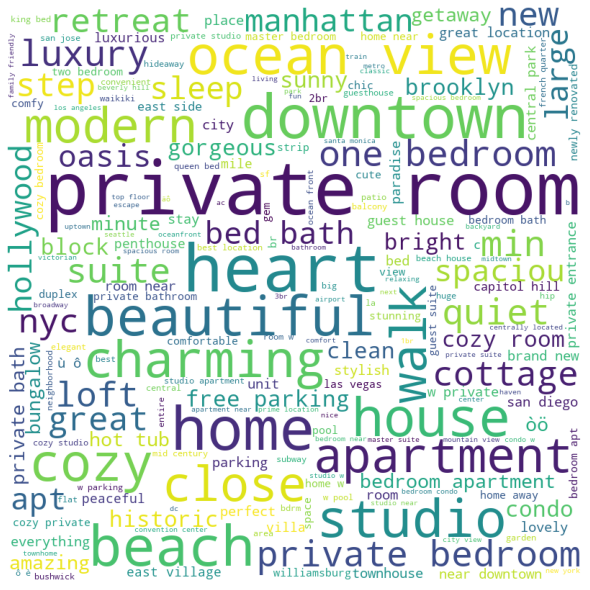

In [16]:
comment = ''
stopwords = set(STOPWORDS)

for i in airbnbDS['name']:
    i = str(i)
    
    tocken = i.split()
    
    for j in range(len(tocken)):
        tocken[j] = tocken[j].lower()
        
    comment += " ".join(tocken)+ " "
    
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Heat map to see if there is any correlations between price and all other numberic columns

<AxesSubplot:>

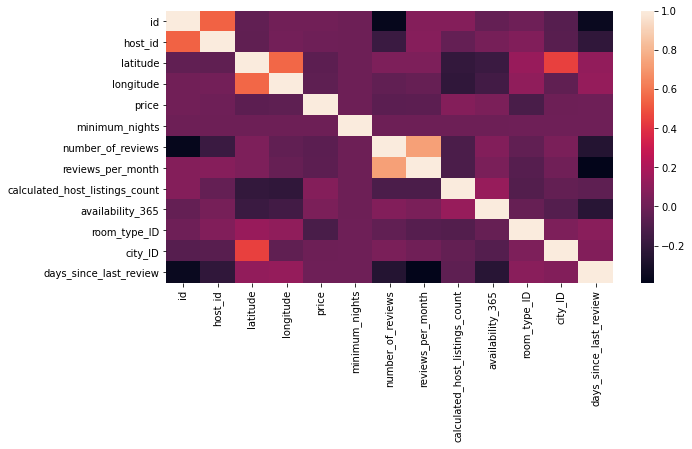

In [17]:
plt.figure(figsize = (10,5))
sns.heatmap(airbnbDS.corr())

Showing prices compared to other categories

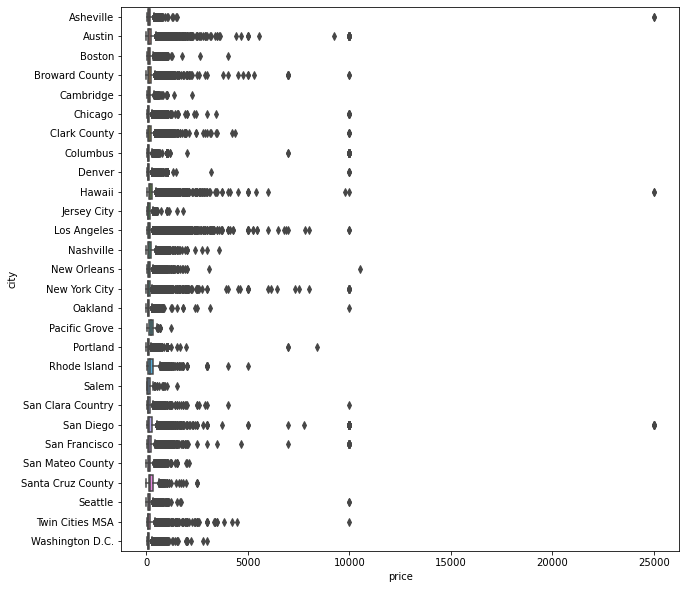

In [18]:
plt.figure(figsize = (10,10))
box_plot = sns.boxplot(x='price', y='city', 
                 data=airbnbDS)

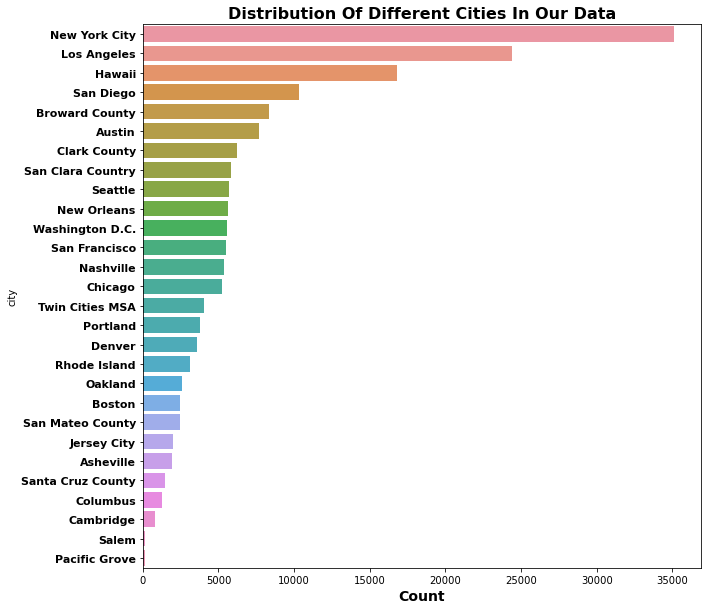

In [19]:
plt.figure(figsize = (10,10))
ax = sns.countplot(y=airbnbDS['city'],order=airbnbDS['city'].value_counts().index)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=11,fontweight='bold')
ax.set_title('Distribution Of Different Cities In Our Data',fontsize=16,fontweight='bold')
ax.set_xlabel('Count',fontsize=14,fontweight='bold')
plt.show()

Creating a profit to see how much money the property can make in a year if it is booked every day it is available

In [20]:
airbnbDS["Profit"] = airbnbDS['price'] * (airbnbDS['availability_365'])

In [21]:
airbnbDS

id                                               name  \
0          38585    Charming Victorian home - twin beds + breakfast   
1          80905                                   French Chic Loft   
2         108061  Walk to stores/parks/downtown. Fenced yard/Pet...   
3         155305                 Cottage! BonPaul + Sharky's Hostel   
4         160594                                Historic Grove Park   
...          ...                                                ...   
225936  45326130      Modern and cozy home located in Washington DC   
225950  45349877  Penthouse w/ Patio ‚òÜ Capitol Hill Condo ‚òÜ ...   
225955  45352724  MODERN ‚òÜ Well-Located Shaw Town Home ‚òÜ 2BR...   
225964  45385834      Brand new modern apartment with private entry   
226002  45472150  LUXE 1-BR STUDIO SPACE / Desirable Location + ...   

          host_id  host_name  \
0          165529    Evelyne   
1          427027    Celeste   
2          320564       Lisa   
3          746673    BonPaul   
4          769252  Elizabeth   
...           ...        ...   
225936   55489711       Amir   
225950    3850096        Ije   
225955    3850096        Ije   
225964   16561471     Victor   
226002  367917574       Tara   

                                            neighbourhood  latitude  \
0                                                   28804  35.65146   
1                                                   28801  35.59779   
2                                                   28801  35.60670   
3                                                   28806  35.57864   
4                                                   28801  35.61442   
...                                                   ...       ...   
225936          Union Station, Stanton Park, Kingman Park  38.90101   
225950                         Capitol Hill, Lincoln Park  38.88703   
225955     Howard University, Le Droit Park, Cardozo/Shaw  38.91626   
225964               Brightwood Park, Crestwood, Petworth  38.94358   
226002  Edgewood, Bloomingdale, Truxton Circle, Eckington  38.91457   

        longitude        room_type  price  minimum_nights  number_of_reviews  \
0       -82.62792     Private room     60               1                138   
1       -82.55540  Entire home/apt    470               1                114   
2       -82.55563  Entire home/apt     75              30                 89   
3       -82.59578  Entire home/apt     90               1                267   
4       -82.54127     Private room    125              30                 58   
...           ...              ...    ...             ...                ...   
225936  -77.00283  Entire home/apt    144               1                  1   
225950  -77.00586  Entire home/apt    132               2                  1   
225955  -77.02074  Entire home/apt    112               2                  1   
225964  -77.01283  Entire home/apt     78               1                  1   
226002  -77.00911  Entire home/apt     76               1                  1   

       last_review  reviews_per_month  calculated_host_listings_count  \
0       2020-02-16               1.14                               1   
1       2020-07-09               1.03                              11   
2       2019-11-30               0.81                               2   
3       2020-09-22               2.39                               5   
4       2015-10-19               0.52                               1   
...            ...                ...                             ...   
225936  2020-09-18               1.00                               1   
225950  2020-09-16               1.00                               8   
225955  2020-09-13               1.00                               8   
225964  2020-09-19               1.00                               1   
226002  2020-09-18               1.00                               1   

        availability_365             city  room_type_ID  city_ID  \
0                

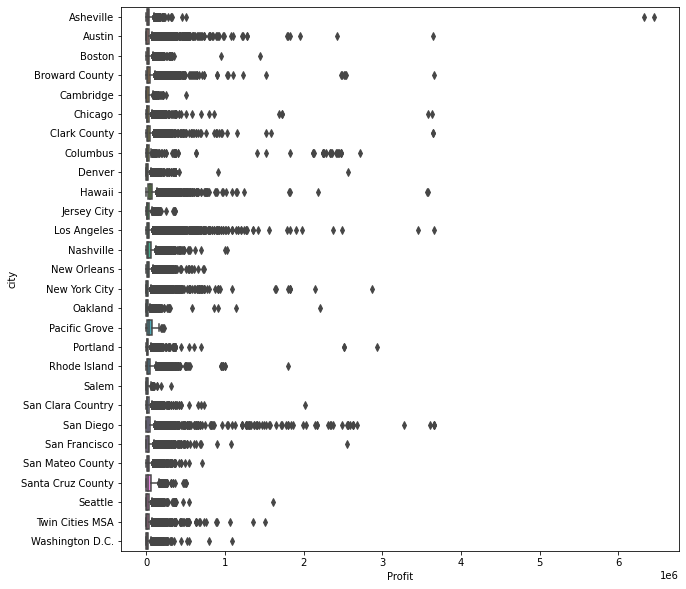

In [22]:
plt.figure(figsize = (10,10))
box_plot = sns.boxplot(x='Profit', y='city', 
                 data=airbnbDS)

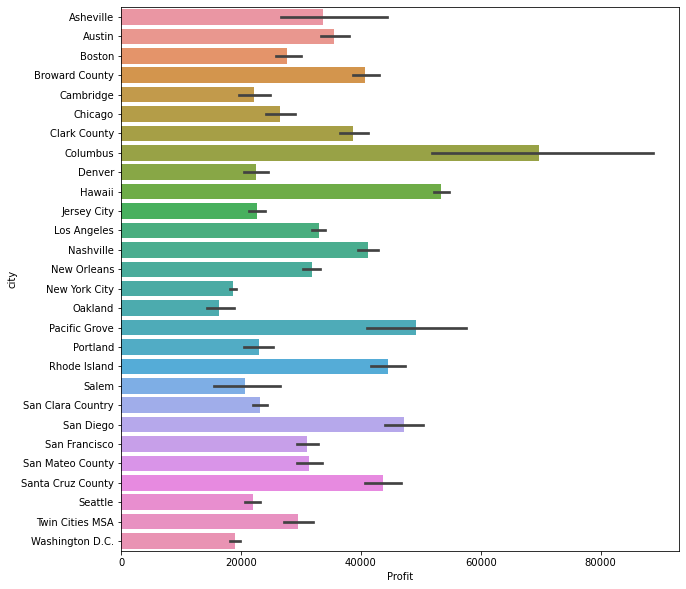

In [23]:
plt.figure(figsize = (10,10))
box_plot = sns.barplot(x='Profit', y='city', 
                 data=airbnbDS)

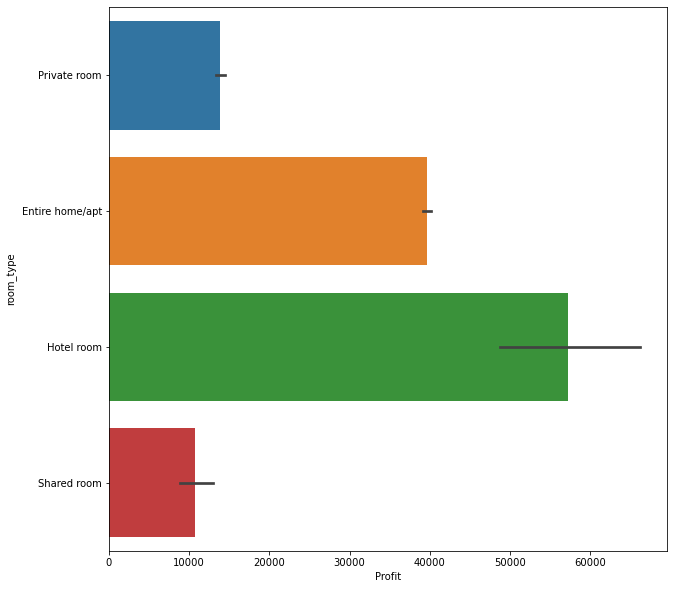

In [24]:
plt.figure(figsize = (10,10))
box_plot = sns.barplot(x='Profit', y='room_type', 
                 data=airbnbDS)

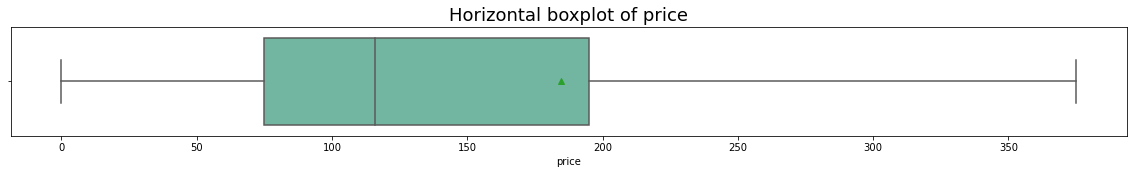

In [25]:
plt.figure(figsize=(20,2))
plt.title("Horizontal boxplot of price", size=18)
sns.boxplot(x="price", data=airbnbDS, showfliers = False, showmeans=True, palette="Set2")
plt.show()

In [26]:
airbnbDS.corr()

id   host_id  latitude  longitude  \
id                              1.000000  0.540372 -0.038278   0.014312   
host_id                         0.540372  1.000000 -0.042855   0.020033   
latitude                       -0.038278 -0.042855  1.000000   0.558152   
longitude                       0.014312  0.020033  0.558152   1.000000   
price                           0.017370  0.005994 -0.058386  -0.049598   
minimum_nights                 -0.001539 -0.002218  0.000711  -0.001756   
number_of_reviews              -0.368653 -0.177309  0.050037  -0.040210   
reviews_per_month               0.072170  0.078894  0.053906  -0.021908   
calculated_host_listings_count  0.076238 -0.029259 -0.203682  -0.213236   
availability_365               -0.029554  0.029986 -0.177410  -0.148488   
room_type_ID                    0.001836  0.062315  0.138919   0.112847   
city_ID                        -0.075898 -0.072053  0.448815  -0.046814   
days_since_last_review         -0.356766 -0.211447  0.119590   0.126213   
Profit                          0.006527  0.009021 -0.100235  -0.078700   

                                   price  minimum_nights  number_of_reviews  \
id                              0.017370       -0.001539          -0.368653   
host_id                         0.005994       -0.002218          -0.177309   
latitude                       -0.058386        0.000711           0.050037   
longitude                      -0.049598       -0.001756          -0.040210   
price                           1.000000       -0.000642          -0.060874   
minimum_nights                 -0.000642        1.000000          -0.001247   
number_of_reviews              -0.060874       -0.001247           1.000000   
reviews_per_month              -0.055226       -0.001790           0.732273   
calculated_host_listings_count  0.076714       -0.000738          -0.113825   
availability_365                0.047300       -0.002710           0.068520   
room_type_ID                   -0.122937        0.002822          -0.039671   
city_ID                        -0.004054        0.003087           0.040011   
days_since_last_review          0.002119        0.005172          -0.255399   
Profit                          0.701144       -0.000868          -0.041179   

                                reviews_per_month  \
id                                       0.072170   
host_id                                  0.078894   
latitude                                 0.053906   
longitude                               -0.021908   
price                                   -0.055226   
minimum_nights                          -0.001790   
number_of_reviews                        0.732273   
reviews_per_month                        1.000000   
calculated_host_listings_count          -0.113099   
availability_365                         0.043291   
room_type_ID                            -0.074901   
city_ID                                  0.007045   
days_since_last_review                  -0.389714   
Profit                                  -0.041754   

                                calculated_host_listings_count  \
id                                                    0.076238   
host_id                                              -0.029259   
latitude                                             -0.203682   
longitude                                            -0.213236   
price                                                 0.076714   
minimum_nights                                       -0.000738   
number_of_reviews                                    -0.113825   
reviews_per_month                                    -0.113099   
calculated_host_listings_count                        1.000000   
availability_365                                      0.132094   
room_type_ID                                         -0.089915   
city_ID                                              -0.032374   
days_since_last_review                               -0.047839   
Profit

Price does not have any correlations besides our self created column of price and a small correlation between room available. 